# MSBA –Optimization 2: Project 2 – Dynamic Programming

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from scipy.stats import binom
# %matplotlib inline

First, we need to set up the parameters of the problem, these will be referenced thorughout the code:

In [2]:
## price for coach ticket
c_priceL = 300
c_priceH = 350
## price for first class ticket
f_priceL = 425
f_priceH = 500

## demand probabilities for coach ticket
c_pL = [0.35,0.65] # demand probabilities for low price
c_pH = [0.7,0.3] # demand probabilities for high price

## demand probabilities for first class ticket
f_pL = [0.92,0.08] # demand probabilities for low price
f_pH = [0.96,0.04] # demand probabilities for high price

delta = 1/(1+0.15/365) # discount rate

overbook = 5 # seat can be overbooked
cap = 100 # coach capacity
c_M1 = cap + overbook # number of seats for coach ticket
f_M1 = 20 # number of seats for first class ticket

T = 365 # days until takeoff

c_p_SU = 0.95 # coach class show up possibility 
f_p_SU = 0.97 # first class show up possibility

cost_f = 50 # cost for first class bump
cost_o = 425  # cost for no-seat bump

# Below, are our three state variables
cValues = np.arange(c_M1+1) # all possible number of seats left in coach
fValues = np.arange(f_M1+1) # all possible number of seats left in first class
tValues = np.arange(T+1) # all possible days until takeoff

cN = len(cValues) # count possible state values
fN = len(fValues) # count possible state values
tN = len(tValues)  # count possible state values

## Question 1
In this phase, we would like to determine the value today, and the optimal decisions at each state when we only allow coach to be oversold by five tickets.




In [3]:
def get_overbook(seats:int):
  """ This function takes in the number of coach seats that are allowed to be overbooked and
      will return four values: Value matrix, Coach Decision Matrix, First Class Decision Matrix, and the discounted profit at time 0.
  """

  cValues = np.arange(cap + seats+1) # all possible number of seats left in coach
  cN = len(cValues)  # count possible state values

  V = np.zeros((cN,fN,tN)) # initialize value function
  U_c = np.zeros((cN,fN,tN)) # initialize optimal choice variable - coach
  U_f = np.zeros((cN,fN,tN)) # initialize optimal choice variable - first class

  #First, we need to set up the terminal condition. This condition is defined as the expected cost at takeoff due to overbooking.
  for i in range(cN):
    for j in range(fN):
      ## sell less or equal than 100 coach tickets
      if i <= cap:
        V[i,j,tN-1] = 0
      ## sell more than 100 coach tickets
      else:
        ## adding up all the possibilities of showing up can come up with expected cost
        cost = 0
        for m in range(i+1):
          for n in range(j+1):
            if m <= cap:
              cost += 0
            else:
              overbook = m - cap 
              firstleft = f_M1 - n
              diff = overbook - firstleft
              if diff <= 0:
                cost += cost_f*overbook*binom.pmf(m, i, c_p_SU)*binom.pmf(n, j, f_p_SU)
              else:
                cost += (cost_f*firstleft+cost_o*diff)*binom.pmf(m, i, c_p_SU)*binom.pmf(n, j, f_p_SU)
        V[i,j,tN-1] = -cost  


  # Now we can loop backward in time, to fill out the value matrix and decision matrices.
  for t in reversed(range(tN-1)):
    for c in range(cN):
        for f in range(fN):

          ## coach class and first class both sold out
          if c ==  cap + seats and f == f_M1: # is the flight full (0 seats left)
              V[c,f,t] = delta*V[c,f,t+1] # if so, you can't make any more money, the same with later period
              U_c[c,f,t] = 0 # no tickets for sale
              U_f[c,f,t] = 0 # no tickets for sale

          ## only coach class sold out
          elif c == cap + seats:
              ## expected revenue today for both two possible price combination in first class
              ErevH_f = f_priceH*f_pH[1] + 0*f_pH[0]
              ErevL_f = f_priceL*f_pL[1] + 0*f_pL[0]
              
              ## tomorrow's expected value
              EtomH_f = V[c,f+1,t+1]*f_pH[1] + V[c,f,t+1]*f_pH[0]
              EtomL_f = V[c,f+1,t+1]*f_pL[1] + V[c,f,t+1]*f_pL[0]

              # value function = expected revenue today + discounted expected value function next time
              valueH_f = ErevH_f + delta*EtomH_f
              valueL_f = ErevL_f + delta*EtomL_f

              V[c,f,t]=max(valueH_f,valueL_f)
              index_f = np.argmax([valueH_f,valueL_f])+1

              ## choice of price: 1 means low price, 2 means high price, 0 means not sold
              U_c[c,f,t] = 0
              if index_f  == 1:
                U_f[c,f,t] = 2
              elif index_f == 2:
                U_f[c,f,t] = 1

          ## only first class sold out
          elif f == f_M1:
              ErevH_c = c_priceH*c_pH[1] + 0*c_pH[0]
              ErevL_c = c_priceL*c_pL[1] + 0*c_pL[0]
              
              ## tomorrow's expected value
              EtomH_c = V[c+1,f,t+1]*c_pH[1] + V[c,f,t+1]*c_pH[0]
              EtomL_c = V[c+1,f,t+1]*c_pL[1] + V[c,f,t+1]*c_pL[0]

              # value function = expected revenue today + discounted expected value function next time
              valueH_c = ErevH_c + delta*EtomH_c
              valueL_c = ErevL_c + delta*EtomL_c

              V[c,f,t]=max(valueH_c,valueL_c)
              index_c = np.argmax([valueH_c,valueL_c])+1

              ## choice of price: 1 means low price, 2 means high price, 0 means not sold
              U_f[c,f,t] = 0
              if index_c  == 1:
                U_c[c,f,t] = 2
              elif index_c == 2:
                U_c[c,f,t] = 1

          ## both available for sale
          else:
              ## expected revenue today for all four possible price combination
              ErevHH = (c_priceH+f_priceH)*c_pH[1]*f_pH[1] + (c_priceH)*c_pH[1]*f_pH[0] + (f_priceH)*c_pH[0]*f_pH[1] + 0*c_pH[0]*f_pH[0]
              ErevHL = (c_priceH+f_priceL)*c_pH[1]*f_pL[1] + (c_priceH)*c_pH[1]*f_pL[0] + (f_priceL)*c_pH[0]*f_pL[1] + 0*c_pH[0]*f_pL[0]
              ErevLH = (c_priceL+f_priceH)*c_pL[1]*f_pH[1] + (c_priceL)*c_pL[1]*f_pH[0] + (f_priceH)*c_pL[0]*f_pH[1] + 0*c_pL[0]*f_pH[0]
              ErevLL = (c_priceL+f_priceL)*c_pL[1]*f_pL[1] + (c_priceL)*c_pL[1]*f_pL[0] + (f_priceL)*c_pL[0]*f_pL[1] + 0*c_pL[0]*f_pL[0]
              
              ## tomorrow's expected value
              EtomHH = V[c+1,f+1,t+1]*c_pH[1]*f_pH[1] + V[c+1,f,t+1]*c_pH[1]*f_pH[0] + V[c,f+1,t+1]*c_pH[0]*f_pH[1] + V[c,f,t+1]*c_pH[0]*f_pH[0]
              EtomHL = V[c+1,f+1,t+1]*c_pH[1]*f_pL[1] + V[c+1,f,t+1]*c_pH[1]*f_pL[0] + V[c,f+1,t+1]*c_pH[0]*f_pL[1] + V[c,f,t+1]*c_pH[0]*f_pL[0]
              EtomLH = V[c+1,f+1,t+1]*c_pL[1]*f_pH[1] + V[c+1,f,t+1]*c_pL[1]*f_pH[0] + V[c,f+1,t+1]*c_pL[0]*f_pH[1] + V[c,f,t+1]*c_pL[0]*f_pH[0]
              EtomLL = V[c+1,f+1,t+1]*c_pL[1]*f_pL[1] + V[c+1,f,t+1]*c_pL[1]*f_pL[0] + V[c,f+1,t+1]*c_pL[0]*f_pL[1] + V[c,f,t+1]*c_pL[0]*f_pL[0]

              # value function = expected revenue today + discounted expected value function next time
              valueHH = ErevHH + delta*EtomHH
              valueHL = ErevHL + delta*EtomHL
              valueLH = ErevLH + delta*EtomLH
              valueLL = ErevLL + delta*EtomLL
              

              V[c,f,t]=max(valueHH,valueHL,valueLH,valueLL) # value funciton maximizes expected revenue
              index = np.argmax([valueHH,valueHL,valueLH,valueLL])+1
              
              ## choice of price: 1 means low price, 2 means high price, 0 means not sold
              if index == 1:
                U_c[c,f,t] = 2
                U_f[c,f,t] = 2
              elif index == 2:
                U_c[c,f,t] = 2
                U_f[c,f,t] = 1
              elif index == 3:
                U_c[c,f,t] = 1
                U_f[c,f,t] = 2
              elif index == 4:
                U_c[c,f,t] = 1
                U_f[c,f,t] = 1

  return V, U_c, U_f, V[0,0,0] # Value matrix, Coach Decision matrix, first clas decision matrix, and discounted value today.

In [4]:
V, U_c, U_f, profit_ob5 = get_overbook(seats=5) # Solve the problem, with 5 overbooking seats allowed

In [5]:
print(f"The current expected discounted profit of allowing 5 seats overbooked is {profit_ob5:,.2F}")

The current expected discounted profit of allowing 5 seats overbooked is 42,242.86


## Question 2

We will now follow the same approach as above, but we would like to explore how the expected present value changes based on different policies that allow us to overbook coach tickets by an increasing number of seats. 

In [6]:
profits = [profit_ob5] # Create a list to store profits and add in the value calculated above for 5.

for i in range(6,16):
  profit = get_overbook(seats=i)[3] # Profit is the fourth returned value in that Tuple
  print(f"The discounted profit of allowing {i} seats overbooked is {profit:,.2F}")
  profits.append(profit)

The discounted profit of allowing 6 seats overbooked is 42,368.87
The discounted profit of allowing 7 seats overbooked is 42,444.24
The discounted profit of allowing 8 seats overbooked is 42,482.21
The discounted profit of allowing 9 seats overbooked is 42,496.11
The discounted profit of allowing 10 seats overbooked is 42,495.97
The discounted profit of allowing 11 seats overbooked is 42,488.26
The discounted profit of allowing 12 seats overbooked is 42,477.00
The discounted profit of allowing 13 seats overbooked is 42,464.60
The discounted profit of allowing 14 seats overbooked is 42,452.36
The discounted profit of allowing 15 seats overbooked is 42,440.94


In [7]:
max_profit = max(profits)
optimal_seats = np.argmax(profits)+5
print(f'The best strategy is to overbook by {optimal_seats} seats which provides and expected discounted profit of {max_profit}.')


The best strategy is to overbook by 9 seats which provides and expected discounted profit of 42496.11230437858.


C:\Users\User\AppData\Local\Temp\ipykernel_4972\1696372957.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


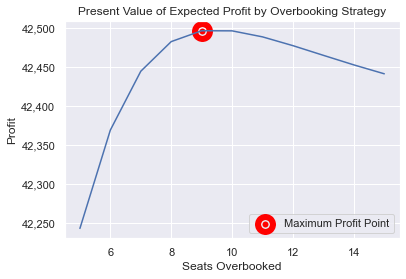

In [8]:
fix, ax = plt.subplots()
plt.plot(range(5,16),profits)
plt.title('Present Value of Expected Profit by Overbooking Strategy')
plt.xlabel('Seats Overbooked')
plt.ylabel('Profit')
ax.scatter(optimal_seats,max_profit,c='red',lw=15,label=f'Maximum Profit Point')
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
plt.legend();

## Question 3

Finally, we consider another third policy approach. In this policy, we allow coach tickets to be overbooked by 20 seats, but we also provide another decision possibility. To not offer coach seats for sale entirely.

In [9]:
overbook = 20 # seat can be overbooked
c_M1 = cap + overbook # number of seats allowed to be sold for coach ticket
cValues = np.arange(c_M1+1) # all possible number of seats left in coach
cN = len(cValues) # count possible state values

V_120 = np.zeros((cN,fN,tN)) # initialize value function
U_c_120 = np.zeros((cN,fN,tN)) # initialize optimal choice variable - coach
U_f_120 = np.zeros((cN,fN,tN)) # initialize optimal choice variable - first class

In [10]:
## boundary/terminal condition
for i in range(cN):
  for j in range(fN):
    ## sell less or equal than 100 coach tickets
    if i <= cap:
      V_120[i,j,tN-1] = 0
    ## sell more than 100 coach tickets
    else:
      ## adding up all the possibilities of showing up can come up with expected cost
      cost = 0
      for m in range(i+1):
        for n in range(j+1):
          if m <= cap:
            cost += 0
          else:
            overbook = m - cap 
            firstleft = f_M1 - n
            diff = overbook - firstleft
            if diff <= 0:
              cost += cost_f*overbook*binom.pmf(m, i, c_p_SU)*binom.pmf(n, j, f_p_SU)
            else:
              cost += (cost_f*firstleft+cost_o*diff)*binom.pmf(m, i, c_p_SU)*binom.pmf(n, j, f_p_SU)
      V_120[i,j,tN-1] = -cost  

In [11]:
for t in reversed(range(tN-1)):
    for c in range(cN):
        for f in range(fN):

          ## coach class and first class both sold out
          if c ==  c_M1 and f == f_M1: # is the flight full (0 seats left)
              V_120[c,f,t] = delta*V_120[c,f,t+1] # if so, you can't make any more money, the same with later period
              U_c_120[c,f,t] = 0 # no tickets for sale
              U_f_120[c,f,t] = 0 # no tickets for sale

          ## only coach class sold out
          elif c == c_M1:
              ## expected revenue today for both two possible price combination in first class
              ErevH_f = f_priceH*f_pH[1] + 0*f_pH[0]
              ErevL_f = f_priceL*f_pL[1] + 0*f_pL[0]
              
              ## tomorrow's expected value
              EtomH_f = V_120[c,f+1,t+1]*f_pH[1] + V_120[c,f,t+1]*f_pH[0]
              EtomL_f = V_120[c,f+1,t+1]*f_pL[1] + V_120[c,f,t+1]*f_pL[0]

              # value function = expected revenue today + discounted expected value function next time
              valueH_f = ErevH_f + delta*EtomH_f
              valueL_f = ErevL_f + delta*EtomL_f

              V_120[c,f,t]=max(valueH_f,valueL_f)
              index_f = np.argmax([valueH_f,valueL_f])+1

              ## choice of price: 1 means low price, 2 means high price, 0 means not sold
              U_c_120[c,f,t] = 0
              if index_f  == 1:
                U_f_120[c,f,t] = 2
              elif index_f == 2:
                U_f_120[c,f,t] = 1

          ## only first class sold out
          elif f == f_M1:
              ErevH_c = c_priceH*c_pH[1] + 0*c_pH[0]
              ErevL_c = c_priceL*c_pL[1] + 0*c_pL[0]
              Erev0_c = 0
              
              ## tomorrow's expected value
              EtomH_c = V_120[c+1,f,t+1]*c_pH[1] + V_120[c,f,t+1]*c_pH[0]
              EtomL_c = V_120[c+1,f,t+1]*c_pL[1] + V_120[c,f,t+1]*c_pL[0]
              Etom0_c = V_120[c,f,t+1]*1


              # value function = expected revenue today + discounted expected value function next time
              valueH_c = ErevH_c + delta*EtomH_c
              valueL_c = ErevL_c + delta*EtomL_c
              value0_c = Erev0_c + delta*Etom0_c

              V_120[c,f,t]=max(valueH_c,valueL_c,value0_c)
              index_c = np.argmax([valueH_c,valueL_c,value0_c])+1

              ## choice of price: 1 means low price, 2 means high price, 0 means not sold
              U_f_120[c,f,t] = 0
              if index_c  == 1:
                U_c_120[c,f,t] = 2
              elif index_c == 2:
                U_c_120[c,f,t] = 1
              elif index_c == 3:
                U_c_120[c,f,t] = 3
              

          ## both available for sale
          else:
              ## expected revenue today for all six possible price combination
              ErevHH = (c_priceH+f_priceH)*c_pH[1]*f_pH[1] + (c_priceH)*c_pH[1]*f_pH[0] + (f_priceH)*c_pH[0]*f_pH[1] + 0*c_pH[0]*f_pH[0]
              ErevHL = (c_priceH+f_priceL)*c_pH[1]*f_pL[1] + (c_priceH)*c_pH[1]*f_pL[0] + (f_priceL)*c_pH[0]*f_pL[1] + 0*c_pH[0]*f_pL[0]
              ErevLH = (c_priceL+f_priceH)*c_pL[1]*f_pH[1] + (c_priceL)*c_pL[1]*f_pH[0] + (f_priceH)*c_pL[0]*f_pH[1] + 0*c_pL[0]*f_pH[0]
              ErevLL = (c_priceL+f_priceL)*c_pL[1]*f_pL[1] + (c_priceL)*c_pL[1]*f_pL[0] + (f_priceL)*c_pL[0]*f_pL[1] + 0*c_pL[0]*f_pL[0]
              Erev0H = (0+f_priceH)*f_pH[1] + 0*f_pH[0] 
              Erev0L = (0+f_priceL)*f_pL[1] + 0*f_pL[0]

              ## tomorrow's expected value
              EtomHH = V_120[c+1,f+1,t+1]*c_pH[1]*f_pH[1] + V_120[c+1,f,t+1]*c_pH[1]*f_pH[0] + V_120[c,f+1,t+1]*c_pH[0]*f_pH[1] + V_120[c,f,t+1]*c_pH[0]*f_pH[0]
              EtomHL = V_120[c+1,f+1,t+1]*c_pH[1]*f_pL[1] + V_120[c+1,f,t+1]*c_pH[1]*f_pL[0] + V_120[c,f+1,t+1]*c_pH[0]*f_pL[1] + V_120[c,f,t+1]*c_pH[0]*f_pL[0]
              EtomLH = V_120[c+1,f+1,t+1]*c_pL[1]*f_pH[1] + V_120[c+1,f,t+1]*c_pL[1]*f_pH[0] + V_120[c,f+1,t+1]*c_pL[0]*f_pH[1] + V_120[c,f,t+1]*c_pL[0]*f_pH[0]
              EtomLL = V_120[c+1,f+1,t+1]*c_pL[1]*f_pL[1] + V_120[c+1,f,t+1]*c_pL[1]*f_pL[0] + V_120[c,f+1,t+1]*c_pL[0]*f_pL[1] + V_120[c,f,t+1]*c_pL[0]*f_pL[0]
              Etom0H = V_120[c,f+1,t+1]*f_pH[1] + V_120[c,f,t+1]*f_pH[0]
              Etom0L = V_120[c,f+1,t+1]*f_pL[1] + V_120[c,f,t+1]*f_pL[0]

              # value function = expected revenue today + discounted expected value function next time
              valueHH = ErevHH + delta*EtomHH
              valueHL = ErevHL + delta*EtomHL
              valueLH = ErevLH + delta*EtomLH
              valueLL = ErevLL + delta*EtomLL
              value0H = Erev0H + delta*Etom0H
              value0L = Erev0L + delta*Etom0L
              

              V_120[c,f,t]=max(valueHH,valueHL,valueLH,valueLL,value0H,value0L) # value funciton maximizes expected revenue
              index = np.argmax([valueHH,valueHL,valueLH,valueLL,value0H,value0L])+1
              
              ## choice of price: 1 means low price, 2 means high price, 0 means not sold
              if index == 1:
                U_c_120[c,f,t] = 2
                U_f_120[c,f,t] = 2
              elif index == 2:
                U_c_120[c,f,t] = 2
                U_f_120[c,f,t] = 1
              elif index == 3:
                U_c_120[c,f,t] = 1
                U_f_120[c,f,t] = 2
              elif index == 4:
                U_c_120[c,f,t] = 1
                U_f_120[c,f,t] = 1
              elif index == 5:
                U_c_120[c,f,t] = 3
                U_f_120[c,f,t] = 2
              elif index == 6:
                U_c_120[c,f,t] = 3
                U_f_120[c,f,t] = 1


In [12]:
print(f'Discounted profit of this policy is: {V_120[0,0,0]:,.2F}')

Discounted profit of this policy is: 42,502.67


We can see that this profit is higher than the maximum profit on the previous approach.

## Question 4: Simulating Scenarios

Now we would like to simulate events using the two optimal decision methods above:

* Method 1: Seats, must be offered for sale every day if it is not sold out and the max allowable overbooking for coach is 9 seats.
* Method 2: Coach seats can be withheld from sale for a given day and the amaximum allowable overbooking is 20 seats.

### Simulating Results of using Optimal Policy for Method 1

In [13]:
sim_count = 100_000 # Number of simulations for each policy
rng = np.random.default_rng() # This object is used for generating random numbers below

Below, we create two helper functions:

In [14]:
def get_overbooking_cost(coach_people:int,fclass_people:int) -> float:
    """Send in the amount of coach people and fclass people that showed up the flight and this will return the dollar cost."""

    if coach_people <= cap:
        return 0 # No cost if less people show up than seats available
    overbooked = coach_people - cap
    fclass_left = 20-fclass_people

    diff = overbooked - fclass_left
    if diff > 0:
        cost = diff*cost_o + fclass_left*cost_f
    else:
        cost = cost_f*overbooked
    return -cost

def simulate_policy(U_c,U_f):

    # Start out with a blank slate
    coach_sold = 0
    fclass_sold = 0
    total_discounted_rev = 0

    # Loop through each day and decide on the decision that would be made for that day regarding pricing.
    # Then, simulate if sales occurred
    for time in range(tN-1): # We only need to simulate through day 364
        coach_decision = U_c[coach_sold,fclass_sold,time]
        fclass_decision = U_f[coach_sold,fclass_sold,time]

        # Figure out the price to charge and the prob of sale for coach
        if coach_decision == 1: # Low Price
            coach_price = c_priceL
            coach_prob = c_pL[1]
        elif coach_decision == 2: # High Price
            coach_price = c_priceH
            coach_prob = c_pH[1]
        else: # No sale is offered, but we can just set the prob of sale equal to 0 to get same result
            coach_price = 0
            coach_prob = 0

        # Figure out the price to charge and the prob of sale for fclass
        if fclass_decision == 1:
            fclass_price = f_priceL
            fclass_prob = f_pL[1]
        elif fclass_decision == 2:
            fclass_price = f_priceH
            fclass_prob = f_pH[1]
        else: # No sale is offered, but we can just set the prob of sale equal to 0 to get same result
            fclass_price = 0
            fclass_prob = 0

        # Simulate the sales
        coach_sale = int(np.random.random() < coach_prob) # This will be a 1 if sale. 0 otherwise
        fclass_sale = int(np.random.random() < fclass_prob) # This will be a 1 if sale. 0 otherwise

        coach_sold += coach_sale
        fclass_sold += fclass_sale

        total_discounted_rev += (coach_price*coach_sale + fclass_price*fclass_sale)*delta**time
        

    return coach_sold, fclass_sold, total_discounted_rev


Now we can simulated the first policy. We first create several arrays to store the results of each simulation, then we beging the simulation. We will loop through time for each simulation and examine a possible sequence of events.

In [15]:
V_9, U_c_9, U_f_9, V009 = get_overbook(9) # Get the decision matrices

# Set up some arrays that we can use to store some of the important final results of each simulation. 
coach_arrived_m1 = np.zeros(sim_count) # How many coach people showed up
fclass_arrived_m1 = np.zeros(sim_count) # How many first class passengers showed up
overbooking_costs_m1 = np.zeros(sim_count) # How much did the overbooking cost us
expected_cost_m1 = np.zeros(sim_count)

total_coach_solds_m1 = np.zeros(sim_count) # How many coach seats were sold
total_fclass_solds_m1 = np.zeros(sim_count) # How many first class seats were sold
discounted_revs_m1 = np.zeros(sim_count) # What was our total discounted rev

In [16]:
# This cell will take 1 minute to run probably.
for sim in range(sim_count):
    coach_sold, fclass_sold, total_discounted_rev = simulate_policy(U_c_9, U_f_9)

    total_coach_solds_m1[sim] = coach_sold
    total_fclass_solds_m1[sim] = fclass_sold
    discounted_revs_m1[sim] = total_discounted_rev

    fclass_arrived_m1[sim] = rng.binomial(fclass_sold,f_p_SU) # Simulate how many people may show up to first class
    coach_arrived_m1[sim] = rng.binomial(coach_sold,c_p_SU) # Simulate how many people may show up to coach
    overbooking_costs_m1[sim] = get_overbooking_cost(coach_arrived_m1[sim],fclass_arrived_m1[sim]) # Store the cost

    expected_cost_m1[sim] = V_9[coach_sold,fclass_sold,-1]

discounted_overbooking_cost_m1 = overbooking_costs_m1*delta**365 
discounted_e_overbooking_cost_m1 = expected_cost_m1*delta**365 
profits_m1 = discounted_revs_m1 + discounted_overbooking_cost_m1

#### Graphical Summary of Simulation

How often is coach overbooked?

In [17]:
sum(total_coach_solds_m1 > cap)/sim_count # as a percent of total simulations

1.0

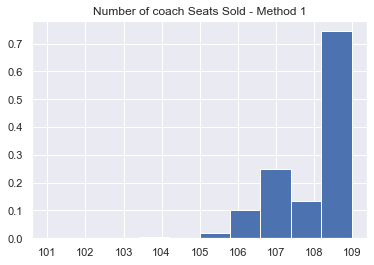

In [18]:
plt.hist(total_coach_solds_m1,density=True) 
plt.title('Number of coach Seats Sold - Method 1');

How often are passengers kicked off plane?

In [19]:
excess_fclass = (f_M1-fclass_arrived_m1)
passengers_kicked_off = np.maximum(coach_arrived_m1 - excess_fclass -  cap,0)

In [20]:
sum(passengers_kicked_off > 0)/sim_count

0.68905

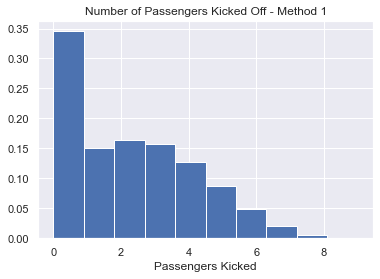

In [21]:
plt.hist(passengers_kicked_off,density=True)
plt.xlabel('Passengers Kicked')
plt.title('Number of Passengers Kicked Off - Method 1');

What is the average overbooking cost?

In [22]:
mean_cost = np.mean(overbooking_costs_m1)
mean_cost

-958.146

C:\Users\User\AppData\Local\Temp\ipykernel_4972\1640241648.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])


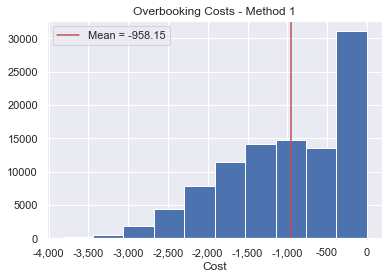

In [23]:
plt.hist(overbooking_costs_m1)
plt.axvline(x=mean_cost,c='r',label=f'Mean = {mean_cost:,.2f}')
plt.legend()
plt.xlabel('Cost')
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])
plt.title('Overbooking Costs - Method 1');

What is the volatility of
discounted profits?

In [24]:
profit_mean = profits_m1.mean()
print(f'Expected Discounted Profit Mean = {profit_mean:,.2f}')
profit_std = profits_m1.std()
print(f'Profit Voaltility = {profit_std:,.2f}')

Expected Discounted Profit Mean = 42,496.90
Profit Voaltility = 941.95


C:\Users\User\AppData\Local\Temp\ipykernel_4972\1143159164.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])


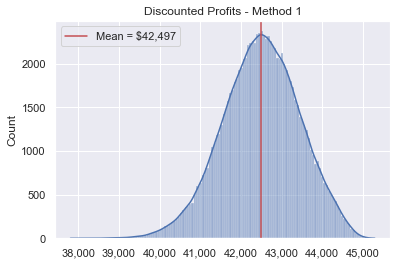

In [25]:
sns.histplot(data=profits_m1,kde=True)
plt.axvline(x=profit_mean,c='r',label=f'Mean = ${profit_mean:,.0f}')
plt.legend()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])
plt.title('Discounted Profits - Method 1');

### Policy 2:
We will use decision matrices that were set in question 3.

In [26]:
# Set up some arrays that we can use to store some of the important final results of each simulation. 
coach_arrived_m2 = np.zeros(sim_count) # How many coach people showed up
fclass_arrived_m2 = np.zeros(sim_count) # How many first class passengers showed up
overbooking_costs_m2 = np.zeros(sim_count) # How much did the overbooking cost us
expected_cost_m2 = np.zeros(sim_count)

total_coach_solds_m2 = np.zeros(sim_count) # How many coach seats were sold
total_fclass_solds_m2 = np.zeros(sim_count) # How many first class seats were sold
discounted_revs_m2 = np.zeros(sim_count) # What was our total discounted rev

In [27]:
# This cell will take 1 minute to run probably.
for sim in range(sim_count):
    coach_sold, fclass_sold, total_discounted_rev = simulate_policy(U_c_120, U_f_120)

    total_coach_solds_m2[sim] = coach_sold
    total_fclass_solds_m2[sim] = fclass_sold
    discounted_revs_m2[sim] = total_discounted_rev

    fclass_arrived_m2[sim] = rng.binomial(fclass_sold,f_p_SU) # Simulate how many people may show up to first class
    coach_arrived_m2[sim] = rng.binomial(coach_sold,c_p_SU) # Simulate how many people may show up to coach
    overbooking_costs_m2[sim] = get_overbooking_cost(coach_arrived_m2[sim],fclass_arrived_m2[sim]) # Store the cost
    expected_cost_m2[sim] = V_120[coach_sold,fclass_sold,-1]

discounted_overbooking_cost_m2 = overbooking_costs_m2*delta**365 
discounted_e_overbooking_cost_m2 = expected_cost_m2*delta**365 

profits_m2 = discounted_revs_m2 + discounted_overbooking_cost_m2

#### Graphical Summary of Simulation

How often is coach overbooked?

In [28]:
sum(total_coach_solds_m2 > cap)/sim_count # as a percent of total simulations

1.0

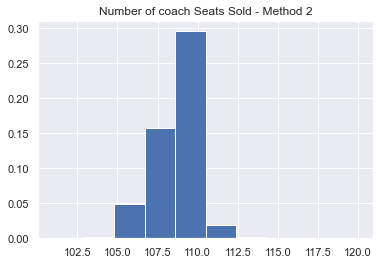

In [29]:
plt.hist(total_coach_solds_m2,density=True) # Why is this plot now lookign weird
plt.title('Number of coach Seats Sold - Method 2');

How often are passengers kicked off plane?

In [30]:
excess_fclass = (f_M1-fclass_arrived_m2)
passengers_kicked_off = np.maximum(coach_arrived_m2 - excess_fclass -  cap,0)

In [31]:
sum(passengers_kicked_off > 0)/sim_count

0.7091

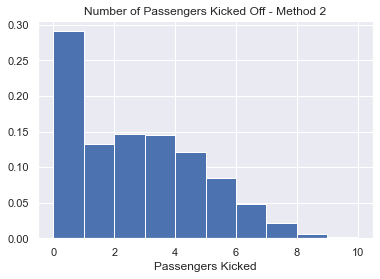

In [32]:
plt.hist(passengers_kicked_off,density=True)
plt.xlabel('Passengers Kicked')
plt.title('Number of Passengers Kicked Off - Method 2');

What is the average overbooking cost?

In [33]:
mean_cost = np.mean(overbooking_costs_m2)
mean_cost

-1014.17375

C:\Users\User\AppData\Local\Temp\ipykernel_4972\3297570470.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])


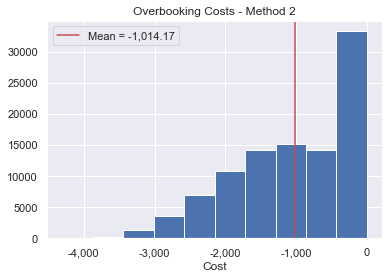

In [34]:
plt.hist(overbooking_costs_m2)
plt.axvline(x=mean_cost,c='r',label=f'Mean = {mean_cost:,.2f}')
plt.legend()
plt.xlabel('Cost')
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])
plt.title('Overbooking Costs - Method 2');

What is the volatility of
discounted profits?

In [35]:
profit_mean2 = profits_m2.mean()
print(f'Expected Discounted Profit Mean = {profit_mean2:,.2f}')
profit_std2 = profits_m2.std()
print(f'Profit Voaltility = {profit_std2:,.2f}')

Expected Discounted Profit Mean = 42,500.85
Profit Voaltility = 951.69


C:\Users\User\AppData\Local\Temp\ipykernel_4972\3602730498.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])


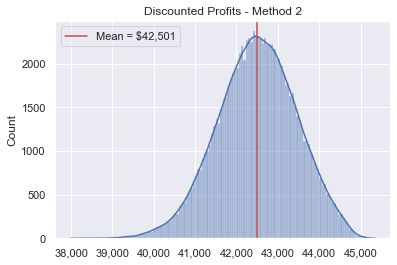

In [36]:
sns.histplot(data=profits_m2,kde=True)
plt.axvline(x=profit_mean2,c='r',label=f'Mean = ${profit_mean2:,.0f}')
plt.legend()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])
plt.title('Discounted Profits - Method 2');

#### Joint Plots

C:\Users\User\AppData\Local\Temp\ipykernel_4972\2560483531.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])


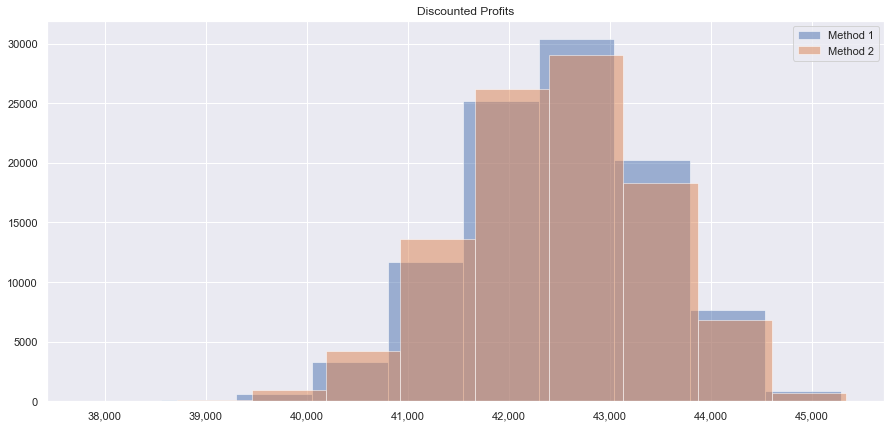

In [37]:
fig, ax = plt.subplots(figsize=(15,7))
plt.hist(profits_m1,alpha=.5,label='Method 1')
plt.hist(profits_m2,alpha=.5,label='Method 2')
# plt.axvline(x=profit_mean2,c='blue',label=f'Mean Method 1: ${profit_mean:,.0f}')
# plt.axvline(x=profit_mean2,c='orange',label=f'Mean Method 2: ${profit_mean2:,.0f}')
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])
plt.title('Discounted Profits');
plt.legend();